### 1. Data - VOC 2007

In [ ]:
!pip install -U albumentations

In [8]:
!pip install opencv-python-headless==4.5.2.52

     |████████████████████████████████| 38.2 MB 111 kB/s 
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.5.5.62
    Uninstalling opencv-python-headless-4.5.5.62:
      Successfully uninstalled opencv-python-headless-4.5.5.62


In [11]:
from torchvision.datasets import VOCDetection
from torchvision.transforms.functional import to_tensor, to_pil_image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init

from PIL import Image, ImageDraw, ImageFont
import os
import xml.etree.ElementTree as ET
from typing import Any, Callable, Dict, Optional, Tuple, List
import warnings
import tarfile
import collections
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline

import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import cv2
from torch import optim
import albumentations as A
import albumentations 
from albumentations.pytorch import ToTensorV2
import os
import time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [12]:
# VOC 2007 dataset을 저장할 위치
path2data = '/content/voc'
if not os.path.exists(path2data):
    os.mkdir(path2data)

In [13]:
# VOC 데이터의 클래스 라벨명
classes = [
    "aeroplane",
    "bicycle",
    "bird",
    "boat",
    "bottle",
    "bus",
    "car",
    "cat",
    "chair",
    "cow",
    "diningtable",
    "dog",
    "horse",
    "motorbike",
    "person",
    "pottedplant",
    "sheep",
    "sofa",
    "train",
    "tvmonitor"
]

In [22]:
class myVOCDetection(VOCDetection):
    def __getitem__(self, index):
        img = np.array(Image.open(self.images[index]).convert('RGB'))
        target = self.parse_voc_xml(ET.parse(self.annotations[index]).getroot()) # xml파일을 dict 형식으로

        targets = []  # bbox 좌표
        labels = []  # bbox 클래스

        # bbox 정보 받아오기
        for t in target['annotation']['object']:
            label = np.zeros(5)
            label[:] = t['bndbox']['xmin'], t['bndbox']['ymin'], t['bndbox']['xmax'], t['bndbox']['ymax'], classes.index(t['name'])

            targets.append(list(label[:4]))  # (xmin, ymin, xmax, ymax)
            labels.append(label[4])        

        if self.transforms:
            augmentations = self.transforms(image=img, bboxes=targets)
            img = augmentations['image']
            targets = augmentations['bboxes']

        return img, targets, labels
    
    # xml -> dict
    def parse_voc_xml(self, node: ET.Element) -> Dict[str, Any]:
        voc_dict: Dict[str, Any] = {}
        children = list(node)
        if children:
            def_dic: Dict[str, Any] = collections.defaultdict(list)
            for dc in map(self.parse_voc_xml, children):
                for ind, v in dc.items():
                    def_dic[ind].append(v)
            if node.tag == "annotation":
                def_dic["object"] = [def_dic["object"]]
            voc_dict = {node.tag: {ind: v[0] if len(v) == 1 else v for ind, v in def_dic.items()}}

        if node.text:
            text = node.text.strip()
            if not children:
                voc_dict[node.tag] = text

        return voc_dict

In [23]:
train_ds = myVOCDetection(path2data, year='2007', image_set='train', download=True)
val_ds = myVOCDetection(path2data, year='2007', image_set='test', download=True)

Using downloaded and verified file: /content/voc/VOCtrainval_06-Nov-2007.tar
Extracting /content/voc/VOCtrainval_06-Nov-2007.tar to /content/voc
Using downloaded and verified file: /content/voc/VOCtest_06-Nov-2007.tar
Extracting /content/voc/VOCtest_06-Nov-2007.tar to /content/voc


In [29]:
img, target, label = train_ds[2]
print('image :', img.shape)  # 이미지
print(target)  # 이미지에 존재하는 모든 object들에 대한 bbox 좌표
print(label)  # 클래스 정보 (1: 자전거 / 14: 사람)

image : (500, 334, 3)
[[9.0, 230.0, 245.0, 500.0], [230.0, 220.0, 334.0, 500.0], [2.0, 178.0, 90.0, 500.0], [2.0, 1.0, 117.0, 369.0], [3.0, 2.0, 243.0, 462.0], [225.0, 1.0, 334.0, 486.0]]
[1.0, 1.0, 1.0, 14.0, 14.0, 14.0]


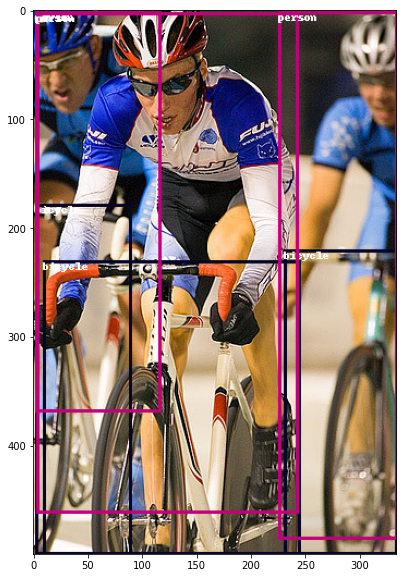

In [30]:
img, target, label = train_ds[2]
colors = np.random.randint(0, 255, size=(80, 3), dtype='uint8') 

def show(img, targets, labels, classes=classes):
    img = to_pil_image(img)
    draw = ImageDraw.Draw(img)
    targets = np.array(targets)
    W, H = img.size

    for tg,label in zip(targets,labels):
        id_ = int(label) # class
        bbox = tg[:4]    # [x1, y1, x2, y2]

        color = [int(c) for c in colors[id_]]
        name = classes[id_]

        draw.rectangle(((bbox[0], bbox[1]), (bbox[2], bbox[3])), outline=tuple(color), width=3)
        draw.text((bbox[0], bbox[1]), name, fill=(255, 255, 255, 0))
    plt.imshow(np.array(img))

plt.figure(figsize=(10, 10))
show(img, target, label)

In [33]:
IMAGE_SIZE = 600
scale = 1.0

train_transforms = A.Compose([
                    A.LongestMaxSize(max_size=int(IMAGE_SIZE * scale)),
                    A.PadIfNeeded(min_height=int(IMAGE_SIZE*scale), min_width=int(IMAGE_SIZE*scale),border_mode=cv2.BORDER_CONSTANT),
                    ToTensorV2()
                    ],
                    bbox_params=A.BboxParams(format='pascal_voc', min_visibility=0.4, label_fields=[])
                    )

val_transforms = A.Compose([
                    A.LongestMaxSize(max_size=int(IMAGE_SIZE * scale)),
                    A.PadIfNeeded(min_height=int(IMAGE_SIZE*scale), min_width=int(IMAGE_SIZE*scale),border_mode=cv2.BORDER_CONSTANT),
                    ToTensorV2()
                    ],
                    bbox_params=A.BboxParams(format='pascal_voc', min_visibility=0.4, label_fields=[])
                    )

# transforms 적용
train_ds.transforms = train_transforms
val_ds.transforms = val_transforms

## 2. DataLoader

In [95]:
class DataEncoder:
    def __init__(self):
        self.anchor_areas = [32*32., 64*64., 128*128., 256*256., 512*512.]  # feature map 크기 (p3 ~ p7)
        self.aspect_ratios = [1/2., 1/1., 2/1.]  # anchor box 종횡비, w/h
        self.scale_ratios = [1., pow(2, 1/3.), pow(2, 2/3.)]  # anchor box scale
        self.anchor_wh = self._get_anchor_wh()
    
    # 각 feature map에서 사용할 anchor box의 넓이, 높이 계산 (종횡비, scale을 고려하여 총 9개)
    def _get_anchor_wh(self):
        anchor_wh = []
        for s in self.anchor_areas:
            for ar in self.aspect_ratios:
                h = math.sqrt(s / ar)
                w = ar * h
                for sr in self.scale_ratios:
                    anchor_h = h*sr
                    anchor_w = w*sr
                    anchor_wh.append([anchor_w, anchor_h])           
        num_fms = len(self.anchor_areas)

        return torch.Tensor(anchor_wh).view(num_fms, -1, 2)  # [# fms, # of anchors per cell, 2], [5, 9, 2]
    
    # feature map의 모든 cell에 anchor box 할당 (한 cell에 9개의 anchor box 존재)
    def _get_anchor_boxes(self, input_size):
        num_fms = len(self.anchor_areas) # 5
        fm_sizes = [(input_size / pow(2., i+3)).ceil() for i in range(num_fms)]

        boxes = []
        for i in range(num_fms):
            fm_size = fm_sizes[i]  # feature map size
            fm_w, fm_h = int(fm_size[0]), int(fm_size[1])
            grid_size = input_size / fm_size  # 각 cell의 size
            xy = self._meshgrid(fm_w, fm_h) + 0.5  # [fm_h * fm_w, 2] - feature map에 존재하는 모든 cell의 index 
            xy = (xy*grid_size).view(fm_h, fm_w, 1, 2).expand(fm_h, fm_w, 9, 2)  # anchor 박스 좌표
            wh = self.anchor_wh[i].view(1, 1, 9, 2).expand(fm_h, fm_w, 9, 2)  # anchor 박스 높이와 너비
            box = torch.cat([xy, wh], 3)  # [x, y, w, h]
            boxes.append(box.view(-1, 4))

        return torch.cat(boxes, 0)

    def encode(self, boxes, labels, input_size):
        input_size = torch.Tensor([input_size, input_size]) if isinstance(input_size, int) else torch.Tensor(input_size)
        anchor_boxes = self._get_anchor_boxes(input_size)  # anchor box 생성
        boxes = self._change_box_order(boxes, 'xyxy2xywh') # bbox 좌표 정보 변경 [x y x y] -> [cx cy w h]

        ious = self._box_iou(anchor_boxes, boxes, order='xywh') # ground-truth box, anchor box의 iou 
        max_ious, max_ids = ious.max(1) # 가장 높은 iou를 지닌 anchor 추출
        boxes = boxes[max_ids]

        # gt, anchor box의 offset 계산
        loc_xy = (boxes[:,:2] - anchor_boxes[:,:2]) / anchor_boxes[:, 2:]
        loc_wh = torch.log(boxes[:, 2:]/anchor_boxes[:, 2:])
        loc_targets = torch.cat([loc_xy, loc_wh], 1)

        # class 할당
        cls_targets = 1 + labels[max_ids]
        cls_targets[max_ious < 0.5] = 0  # iou < 0.5 anchor는 negative
        ignore = (max_ious > 0.4) & (max_ious < 0.5)  # [0.4, 0.5] 는 무시
        cls_targets[ignore] = -1

        return loc_targets, cls_targets

    def decode(self,loc_preds, cls_preds, input_size):
        cls_thresh = 0.5
        nms_thresh = 0.5

        input_size = torch.Tensor([input_size,input_size]) if isinstance(input_size, int) else torch.Tensor(input_size)
        anchor_boxes = self._get_anchor_boxes(input_size)  # anchor box 생성

        loc_xy = loc_preds[:, :2] # 결과값 offset 추출
        loc_wh = loc_preds[:, 2:]

        xy = loc_xy * anchor_boxes[:, 2:] + anchor_boxes[:, :2] # offset + anchor
        wh = loc_wh.exp() * anchor_boxes[:, 2:]
        boxes = torch.cat([xy-wh/2, xy+wh/2], 1)

        score, labels = cls_preds.sigmoid().max(1)
        ids = score > cls_thresh
        ids = ids.nonzero().squeeze()
        keep = self._box_nms(boxes[ids], score[ids], threshold=nms_thresh) # nms

        return boxes[ids][keep], labels[ids][keep]

    def _meshgrid(self, x, y, row_major=True):
        a = torch.arange(0,x)
        b = torch.arange(0,y)
        xx = a.repeat(y).view(-1,1)
        yy = b.view(-1,1).repeat(1,x).view(-1,1)
        return torch.cat([xx,yy],1) if row_major else torch.cat([yy,xx],1)
    
    # x1,y1,x2,y2 <-> cx,cy,w,h
    def _change_box_order(self, boxes, order):
        assert order in ['xyxy2xywh','xywh2xyxy']
        boxes = np.array(boxes)
        a = boxes[:,:2]
        b = boxes[:,2:]
        a, b = torch.Tensor(a), torch.Tensor(b)
        if order == 'xyxy2xywh':
            return torch.cat([(a+b)/2,b-a+1],1) # xywh

        return torch.cat([a-b/2, a+b/2],1) # xyxy

    # 두 박스의 iou 계산
    def _box_iou(self, box1, box2, order='xyxy'):
        if order == 'xywh':
            box1 = self._change_box_order(box1, 'xywh2xyxy')
            box2 = self._change_box_order(box2, 'xywh2xyxy')
        
        N = box1.size(0)
        M = box2.size(0)

        lt = torch.max(box1[:, None, :2], box2[:, :2])
        rb = torch.min(box1[:, None, 2:], box2[:, 2:])

        wh = (rb-lt+1).clamp(min=0)
        inter = wh[:, :, 0] * wh[:, :, 1]

        area1 = (box1[:, 2] - box1[:, 0] + 1) * (box1[:, 3] - box1[:, 1] + 1)
        area2 = (box2[:, 2] - box2[:, 0] + 1) * (box2[:, 3] - box2[:, 1] + 1)
        iou = inter / (area1[:, None] + area2 - inter)

        return iou       

    def _box_nms(self, bboxes, scores, threshold=0.5, mode='union'):
        x1 = bboxes[:, 0]
        y1 = bboxes[:, 1]
        x2 = bboxes[:, 2]
        y2 = bboxes[:, 3]

        areas = (x2-x1+1) * (y2-y1+1)
        _, order = scores.sort(0, descending=True) # confidence 순 정렬
        keep = []
        while order.numel() > 0:
            if order.numel() == 1:
                keep.append(order.data)
                break
            i = order[0] # confidence 가장 높은 anchor 추출
            keep.append(i) # 최종 detection에 저장

            xx1 = x1[order[1:]].clamp(min=x1[i])
            yy1 = y1[order[1:]].clamp(min=y1[i])
            xx2 = x2[order[1:]].clamp(max=x2[i])
            yy2 = y2[order[1:]].clamp(max=y2[i])

            w = (xx2-xx1+1).clamp(min=0)
            h = (yy2-yy1+1).clamp(min=0)
            inter = w*h

            if mode == 'union':
                ovr = inter / (areas[i] + areas[order[1:]] - inter)
            elif mode == 'min':
                ovr = inter / areas[order[1:]].clamp(max=areas[i])
            else:
                raise TypeError('Unknown nms mode: %s.' % mode)

            ids = (ovr<=threshold).nonzero().squeeze()
            if ids.numel() == 0:
                break
            order = order[ids+1]
        return torch.LongTensor(keep)          

In [35]:
def collate_fn(batch):
    encoder = DataEncoder()
    imgs = [x[0] for x in batch]
    boxes = [torch.Tensor(x[1]) for x in batch]
    labels = [torch.Tensor(x[2]) for x in batch]
    h,w = 600, 600
    num_imgs = len(imgs)
    inputs = torch.zeros(num_imgs, 3, h, w)

    loc_targets = []
    cls_targets = []
    for i in range(num_imgs):
        inputs[i] = imgs[i]
        loc_target, cls_target = encoder.encode(boxes=boxes[i], labels=labels[i], input_size=(w,h))
        loc_targets.append(loc_target)
        cls_targets.append(cls_target)
        
    return inputs, torch.stack(loc_targets), torch.stack(cls_targets)

In [36]:
train_dl = DataLoader(train_ds, batch_size=4, shuffle=True, collate_fn=collate_fn)
val_dl = DataLoader(val_ds, batch_size=4, shuffle=True, collate_fn=collate_fn)

## 3. Model

### 3.1 Backbone

ResNet + FPN

`Build FPN on top of the ResNet architecture`



![image](https://user-images.githubusercontent.com/44194558/152916655-8d2acec6-6768-429f-ac38-a59f1b6aeb48.png)

In [54]:
# Bottleneck of ResNet
class Bottleneck(nn.Module):
    expand = 4
    def __init__(self, in_channels, inner_channels, stride=1):
        super().__init__()
        
        ## 3회의 Conv 연산이 하나의 block 구성 
        # 1x1 Conv
        self.conv1 = nn.Conv2d(in_channels, inner_channels, 1, stride=1, padding=0, bias=False)
        self.bn1 = nn.BatchNorm2d(inner_channels)
        
        # 3x3 Conv
        self.conv2 = nn.Conv2d(inner_channels, inner_channels, 3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(inner_channels)
        
        # 1x1 Conv
        self.conv3 = nn.Conv2d(inner_channels, inner_channels * self.expand, 1, stride=1, padding=0)
        self.bn3 = nn.BatchNorm2d(inner_channels * self.expand)
        
        # Shortcut
        self.downsample = nn.Sequential()
        if stride != 1 or in_channels != inner_channels * self.expand:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, inner_channels * self.expand, 1, stride=stride, bias=False),
                nn.BatchNorm2d(inner_channels * self.expand)
            )
        self.relu = nn.ReLU()

    def forward(self, x):
        output = self.relu(self.bn1(self.conv1(x)))  # [1, 56, 13, 13]
        output = self.relu(self.bn2(self.conv2(output)))  # [1, 56, 13, 13]
        output = self.bn3(self.conv3(output))  # [1, 224, 13, 13]

        # skip-conn
        output = self.relu(output + self.downsample(x))

        return output

In [55]:
x = torch.randn(1, 56, 13, 13) 
net = Bottleneck(x.size(1), x.size(1))  # in_channel=inner_channel=56
output = net(x)
print(output.size())

torch.Size([1, 224, 13, 13])


![image](https://user-images.githubusercontent.com/44194558/152919640-c8b424cc-1990-40b2-aa01-c393eed8df4b.png)


In [56]:
class FPN(nn.Module):
    def __init__(self, num_blocks):
        super(FPN, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, 64, 7, stride=2, padding=3, bias=False)  # [3, 64, 300, 300]
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(3, stride=2, padding=1)  # [3, 64, 150, 150]
        
        # Bottom-up layers - ResNet 순전파 (num_blocks=[3, 4, 6, 3])
        self.layer1 = self._make_layer(64, num_blocks[0], stride=1)  # c2 - [3, 256, 150, 150]
        self.layer2 = self._make_layer(128, num_blocks[1], stride=2)  # c3 - [3, 512, 75, 75]
        self.layer3 = self._make_layer(256, num_blocks[2], stride=2)  # c4 - [3, 1024, 38, 38]
        self.layer4 = self._make_layer(512, num_blocks[3], stride=2)  # c5 - [3, 2048, 19, 19]

        self.conv6 = nn.Conv2d(2048, 256, 3, stride=2, padding=1)  # p6
        self.conv7 = nn.Sequential(                                    
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, stride=2, padding=1)  # p7  
        )
        
        # Lateral layers
        self.lateral_1 = nn.Conv2d(2048, 256, 1, stride=1, padding=0)
        self.lateral_2 = nn.Conv2d(1024, 256, 1, stride=1, padding=0)
        self.lateral_3 = nn.Conv2d(512, 256, 1, stride=1, padding=0)

        # Top-down layers
        self.top_down_1 = nn.Conv2d(256, 256, 3, stride=1, padding=1)
        self.top_down_2 = nn.Conv2d(256, 256, 3, stride=1, padding=1)
        
        # 상위 layer feature map에 대한 Up-sampling (해상도는 높이고, 채널 수는 줄임)
        self.upsample_1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        self.upsample_2 = nn.Upsample(size=(75, 75), mode='bilinear', align_corners=False)  # size=(75, 75)를 지정
 
    def _make_layer(self, inner_channels, num_block, stride):
        strides = [stride] + [1] * (num_block-1)  # 3회의 합성곱 연산으로 구성된 block이 3개 모여 하나의 layer를 구성
        layers = []
        for stride in strides:
            layers.append(Bottleneck(self.in_channels, inner_channels, stride=stride))
            self.in_channels = inner_channels * Bottleneck.expand
        
        return nn.Sequential(*layers)

    def forward(self, x):
        # Feature extractor(ResNet) - 각 layer의 feature map을 재사용하기 위해 저장
        c1 = self.relu(self.bn1(self.conv1(x)))  # [3, 64, 300, 300]
        c1 = self.maxpool(c1)  # [3, 64, 150, 150]
        c2 = self.layer1(c1)  # [3, 256, 150, 150]
        c3 = self.layer2(c2)  # [3, 512, 75, 75]
        c4 = self.layer3(c3)  # [3, 1024, 38, 38]
        c5 = self.layer4(c4)  # [3, 2048, 19, 19]

        # FPN
        p6 = self.conv6(c5)  # [3, 256, 10, 10]
        p7 = self.conv7(p6)  # [3, 256, 5, 5]
        
        # Feature fusion (Top down & Lateral connections)
        p5 = self.lateral_1(c5)  # [3, 256, 19, 19]
        p4 = self.top_down_1(self.upsample_1(p5) + self.lateral_2(c4))  # [3, 256, 38, 38]
        p3 = self.top_down_2(self.upsample_2(p4) + self.lateral_3(c3))  # [3, 256, 75, 75]

        return p3, p4, p5, p6, p7  # multi-scale feature maps

def FPN50():
    return FPN([3, 4, 6, 3])

In [57]:
x = torch.randn(3, 3, 600, 600)
model = FPN50()
outputs = model(x)

In [62]:
print('# of feature maps', len(outputs))
print('p3 :', outputs[0].shape)
print('p4 :', outputs[1].shape)
print('p5 :', outputs[2].shape)
print('p6 :', outputs[3].shape)
print('p7 :', outputs[4].shape)

# of feature maps 5
p3 : torch.Size([3, 256, 75, 75])
p4 : torch.Size([3, 256, 38, 38])
p5 : torch.Size([3, 256, 19, 19])
p6 : torch.Size([3, 256, 10, 10])
p7 : torch.Size([3, 256, 5, 5])


### 3.2 RetinaNet with Classification Subnet

`This subnet is a small FCN attached to each FPN level.`

In [63]:
class RetinaNet(nn.Module):
    num_anchors = 9

    def __init__(self, num_classes=20):
        super().__init__()
        self.fpn = FPN50()
        self.num_classes = num_classes
        self.loc_head = self._make_head(self.num_anchors * 4) # bbox regressor
        self.cls_head = self._make_head(self.num_anchors * self.num_classes)  # object classification

    def forward(self, x):
        fms = self.fpn(x)  # p3, p4, p5, p6, p7
        loc_preds = []
        cls_preds = []
        for fm in fms:
            loc_pred = self.loc_head(fm)
            cls_pred = self.cls_head(fm)
            loc_pred = loc_pred.permute(0, 2, 3, 1).contiguous().view(x.size(0), -1, 4)  # [N, 9*4, H, W] -> [N, H, W, 9*4] -> [N, H*W*9, 4]
            cls_pred = cls_pred.permute(0, 2, 3, 1).contiguous().view(x.size(0), -1, self.num_classes) # [N, 9*20, H, W] -> [N, H, W, 9*20] -> [N, H*W*9, 20]
            loc_preds.append(loc_pred)
            cls_preds.append(cls_pred)

        return torch.cat(loc_preds, 1), torch.cat(cls_preds, 1)
    
    # 예측 수행 layer
    def _make_head(self, out_channels): 
        layers = []
        for _ in range(4):
            layers.append(nn.Conv2d(256, 256, 3, stride=1, padding=1))
            layers.append(nn.ReLU())
        layers.append(nn.Conv2d(256, out_channels, 3, stride=1, padding=1)) # (N, 9*4, H, W) or (N, 9*20, H, W) 

        return nn.Sequential(*layers)     

    def freeze_bn(self):  # 사전 학습된 모델 사용
        for layer in self.modules():
            if isinstance(layer, nn.BatchNorm2d):
                layer.eval()  

In [64]:
x = torch.randn(10, 3, 600, 600)
model = RetinaNet()
loc_preds, cls_preds = model(x)
print(loc_preds.size()) # (N, 5 * H*W *9, 4) - 5개의 feature map 당 각각 9개의 anchor box 존재
print(cls_preds.size()) # (N, 5 * H*W *9, 20)

torch.Size([10, 67995, 4])
torch.Size([10, 67995, 20])


## 4. Train

### 4.1 사전 학습된 가중치 불러오기

In [65]:
# 사전 학습된 ResNet50의 가중치 다운로드 'https://download.pytorch.org/models/resnet50-19c8e357.pth'
!wget 'https://download.pytorch.org/models/resnet50-19c8e357.pth'

--2022-02-08 05:12:01--  https://download.pytorch.org/models/resnet50-19c8e357.pth
Resolving download.pytorch.org (download.pytorch.org)... 99.86.38.106, 99.86.38.96, 99.86.38.37, ...
Connecting to download.pytorch.org (download.pytorch.org)|99.86.38.106|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 102502400 (98M) [application/octet-stream]
Saving to: ‘resnet50-19c8e357.pth’

resnet50-19c8e357.p 100%[===================>]  97.75M  13.2MB/s    in 8.8s    

2022-02-08 05:12:10 (11.2 MB/s) - ‘resnet50-19c8e357.pth’ saved [102502400/102502400]



ResNet 50은 사전 학습된 가중치 이용, FPN 가중치는 F.C layer를 제외하고 사전 학습된 가중치 이용

RetinaNet의 가중치는 최종 layer를 제외하고 초기화 (가우시안)

In [67]:
# 가중치 불러오기
path2weight = '/content/resnet50-19c8e357.pth' 
d = torch.load(path2weight) 

# FPN에 사전 학습된 가중치 받아오기
fpn = FPN50()               
dd = fpn.state_dict()  # FPN의 파라미터
for k in d.keys():          
    if not k.startswith('fc'): 
        dd[k] = d[k]       

# RetinaNet 가중치 초기화
model = RetinaNet()         
for m in model.modules():
    # Conv 가중치 초기화
    if isinstance(m, nn.Conv2d):
        init.normal_(m.weight, mean=0, std=0.01)
        if m.bias is not None:
            init.constant_(m.bias, 0)
    
    # B.N 가중치 초기화        
    elif isinstance(m, nn.BatchNorm2d):
        m.weight.data.fill_(1)
        m.bias.data.zero_()

pi = 0.01
init.constant_(model.cls_head[-1].bias, -math.log((1-pi) / pi))

model.fpn.load_state_dict(dd)  # fpn의 가중치를 사전 학습된 가중치로 변경
torch.save(model.state_dict(), 'model.pth') # 가중치 저장

### 4.2 Loss

![image](https://user-images.githubusercontent.com/44194558/152933551-c3bea46c-78df-4a56-a38f-c6d4533f44b2.png)


In [68]:
# label를 one-hot encoding 형식으로
def one_hot_embedding(labels, num_classes):
    ''' labels: class labels, sized [N,]
        num_classes: 클래스 수 20 '''
    y = torch.eye(num_classes) # [20, 20]
    np_labels = np.array(labels)

    return y[np_labels]  # 총 20개의 클래스 라벨에 대한 one-hot encoding 표현

In [73]:
class FocalLoss(nn.Module):
    def __init__(self, num_classes=20):
        super().__init__()
        self.num_classes = num_classes 

    # alternative focal loss
    def focal_loss_alt(self, x, y):
        alpha = 0.25

        t = one_hot_embedding(y.data.cpu(), 1+self.num_classes)
        t = t[:, 1:] # 배경 제외
        t = t.cuda()

        xt = x*(2*t - 1) # xt = x if t > 0 else -x
        pt = (2*xt + 1).sigmoid()

        w = alpha*t + (1-alpha)*(1-t)
        loss = -w*pt.log() / 2

        return loss.sum()

    def forward(self, loc_preds, loc_targets, cls_preds, cls_targets):
        '''(loc_preds, loc_targets)와 (cls_preds, cls_targets) 사이의 loss 계산
           loc_preds: [batch_size, 9, 4]
           loc_targets: [batch_size, 9, 4]
           cls_preds: [batch_size, 9, 20]
           cls_targets: [batch_size, 9] 

           loss = SmoothL1Loss(loc_preds, loc_targets) + FocalLoss(cls_preds, cls_targets)'''

        batch_size, num_boxes = cls_targets.size()
        pos = cls_targets > 0
        num_pos = pos.data.long().sum()

        # loc_loss = SmoothL1Loss(pos_loc_preds, pos_loc_targets)
        mask = pos.unsqueeze(2).expand_as(loc_preds)  # [N, 9, 4]
        masked_loc_preds = loc_preds[mask].view(-1, 4)      # [# of positive, 4]
        masked_loc_targets = loc_targets[mask].view(-1, 4) # [# of positive, 4]

        loc_loss = F.smooth_l1_loss(masked_loc_preds, masked_loc_targets, reduction='sum')

        # cls_loss = FocalLoss(loc_preds, loc_targets)
        pos_neg = cls_targets > -1 # ground truth가 할당되지 않은 anchor 삭제
        mask = pos_neg.unsqueeze(2).expand_as(cls_preds)
        masked_cls_preds = cls_preds[mask].view(-1, self.num_classes)

        cls_loss = self.focal_loss_alt(masked_cls_preds, cls_targets[pos_neg])

        loss = (loc_loss + cls_loss) / num_pos

        return loss

In [74]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

loss_func = FocalLoss()
opt = optim.Adam(model.parameters(), lr=0.001)
lr_scheduler = ReduceLROnPlateau(opt, mode='min', factor=0.1, patience=15)

# 현재 lr 계산
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

# batch당 loss 계산
def loss_batch(loss_func, loc_preds, loc_targets, cls_preds, cls_targets, opt=None):
    loss_b = loss_func(loc_preds, loc_targets, cls_preds, cls_targets)
    
    if opt is not None:
        opt.zero_grad()
        loss_b.backward()
        opt.step()
    
    return loss_b.item()

# epoch당 loss 계산
def loss_epoch(model, loss_func, dataset_dl, sanity_check=False, opt=None):
    running_loss = 0.0
    len_data = len(dataset_dl.dataset)

    for img, loc_targets, cls_targets in dataset_dl:
        img, loc_targets, cls_targets = img.to(device), loc_targets.to(device), cls_targets.to(device)
        loc_preds, cls_preds = model(img)  # pred

        loss_b = loss_batch(loss_func, loc_preds, loc_targets, cls_preds, cls_targets, opt)  # loss
        
        running_loss += loss_b

        if sanity_check is True:
            break

    loss = running_loss / len_data

    return loss

In [92]:
def train_val(model, params):
    num_epochs=params['num_epochs']
    loss_func=params['loss_func']
    opt=params['optimizer']
    train_dl=params['train_dl']
    val_dl=params['val_dl']
    sanity_check=params['sanity_check']
    lr_scheduler=params['lr_scheduler']
    path2weights=params['path2weights']

    loss_history = {'train': [], 'val': []} # loss history 기록

    best_loss = float('inf')
    torch.save(model.state_dict(),path2weights) # 가중치 저장
    start_time = time.time() # 시간 체크

    for epoch in range(num_epochs):
        current_lr = get_lr(opt)
        print('Epoch {}/{}, current lr = {}'.format(epoch, num_epochs-1, current_lr))

        model.train()
        model.freeze_bn() # bn freeze
        train_loss = loss_epoch(model, loss_func, train_dl, sanity_check, opt) # loss 계산
        loss_history['train'].append(train_loss) # loss 기록

        model.eval()
        with torch.no_grad():
            val_loss = loss_epoch(model, loss_func, val_dl, sanity_check)
        loss_history['val'].append(val_loss)

        if val_loss < best_loss: # 가장 낮은 loss 달성시에 가중치 저장
            best_loss = val_loss
            torch.save(model.state_dict(),path2weights)
            print('Copied best model weights!')

        lr_scheduler.step(val_loss) # lr 갱신

        if current_lr != get_lr(opt): # lr이 갱신되었으면 가중치 불러오기
            print('Loading best model weights')
            torch.load(path2weight)

        print('train loss: %.6f, val loss: %.6f, time: %.4f min' %(train_loss, val_loss, (time.time()-start_time)/60))

    torch.load(path2weight) # 학습이 마치면 가중치 저장

    return model, loss_history

In [93]:
# train 파라미터 정의
params_train = {
    'num_epochs':10,
    'optimizer':opt,
    'loss_func':loss_func,
    'train_dl':train_dl,
    'val_dl':val_dl,
    'sanity_check':False,
    'lr_scheduler':lr_scheduler,
    'path2weights':'./models/weights.pt',
}

# 가중치 저장할 폴더 생성
import os

def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSerror:
        print('Error')
createFolder('./models')

In [96]:
model = RetinaNet().to(device)
model, loss_hist = train_val(model, params_train)

Epoch 0/9, current lr = 0.001
Copied best model weights!
train loss: 546.696816, val loss: 570.762726, time: 9.9128 min
Epoch 1/9, current lr = 0.001


KeyboardInterrupt: ignored